# Belgium Taffic Sign Dataset

## INDICE
 0. CARGA DE DATOS
 1. MODELO
 2. VISUALIZACIÓN DE LOS PESOS
 3. CONFUSSION MATRIX
 4. PORCENTAJE DE ACIERTOS

## 1. CARGA DE DATOS

In [3]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import csv
import math

# Allow image embeding in notebook
%matplotlib inline

In [4]:
def load_data(data_dir, width, height):
    directories = [d for d in os.listdir(data_dir) 
                 if os.path.isdir(os.path.join(data_dir, d))]

    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        for f in file_names:
            labels.append(int(d))
            images.append(skimage.transform.resize(skimage.data.imread(f), (width, height)))
    
    labels=np.array(labels)
    images=np.array(images)
    
    return images, labels

In [5]:
train_data_dir = ".\\data\\Training"            
X_train_orig, Y_train_orig = load_data(train_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [6]:
type(X_train_orig)

numpy.ndarray

In [7]:
print(X_train_orig.shape)

(4575, 32, 32, 3)


In [8]:
test_data_dir = ".\\data\\Testing" 
X_test_orig, Y_test_orig = load_data(test_data_dir,32,32)

D:\ANACONDA\envs\tensorflow\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [9]:
print(Y_train_orig)

[ 0  0  0 ... 61 61 61]


In [10]:
print(Y_train_orig.shape)

(4575,)


## 2. Modelo 1

In [11]:
class Model1():
    #***BASIC MODEL WITH 1 FC LAYER***
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            #Placeholders
            self.images=tf.placeholder(tf.float32,(None,32, 32,3), name='images')
            self.labels=tf.placeholder(tf.int32, [None], name='labels')
            #Flatten input
            self.images_flat=tf.contrib.layers.flatten(self.images)
            #Fully connected layer
            self.logits=tf.contrib.layers.fully_connected(self.images_flat,62, tf.nn.relu)
            #print(self.logits)
            #Convert one hot vector to label indexes (int)
            self.predicted_labels=tf.argmax(self.logits,1)
            #Loss
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                    logits=self.logits, labels=self.labels))
            #Training
            self.train=tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.loss)
            #Initialization
            self.init=tf.global_variables_initializer()
            #Create session
            self.session=tf.Session()
            #Run Initialization
            self.session.run(self.init)
        

In [12]:
def train(model, images, labels, test_images, test_labels, train_count, imprimir=True):
    #Training loop
    costs_test=[]
    acc_test=[]
    costs_train=[]
    acc_train=[]
    for i in range(train_count):
        if i % 10 == 0:
            loss_test, accuracy_test = evaluate(model, test_images, test_labels, i, imprimir)
            costs_test.append(loss_test)
            acc_test.append(accuracy_test)
            loss_train, accuracy_train = evaluate(model, images, labels, i, imprimir)
            costs_train.append(loss_train)
            acc_train.append(accuracy_train)
            if imprimir == True:
                print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(i,loss_train, accuracy_train))
                print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(i,loss_test, accuracy_test))
        
        model.session.run(model.train,{
            model.images:images,
            model.labels:labels})
            
    #Final evaluation
    loss_test, accuracy_test=evaluate(model, test_images, test_labels,i, imprimir=True)
    costs_test.append(loss_test)
    acc_test.append(accuracy_test)
    loss_train, accuracy_train = evaluate(model, images, labels, i, imprimir=True)
    costs_train.append(loss_train)
    acc_train.append(accuracy_train)
    print("{:4}, Loss: {:.3f}  Train accuracy: {:.3f}".format(i,loss_train, accuracy_train))
    print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(i,loss_test, accuracy_test))
    
    if imprimir == True:
        # plot the cost    
        plt.plot(np.squeeze(acc_train), label='Train')
        plt.plot(np.squeeze(acc_test), label='Test')
        plt.ylabel('Precisión')
        plt.xlabel('Iteraciones por centenares')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()
        plt.plot(np.squeeze(costs_test), label='Test')
        plt.ylabel('Coste')
        plt.xlabel('iteraciones por centenares')
        plt.show()

#TODO: evaluate training loss and accuracy

def evaluate(model, images, labels, step, imprimir=True):
    #Run predictions against the full test set
    #print(images.shape)
    #print(labels.shape)
    predicted, loss = model.session.run([model.predicted_labels, model.loss],
                                       {model.images: images, model.labels:labels})
    #Calculate accuracy and print
    accuracy=np.sum(labels == predicted)/labels.shape[0]
    #if imprimir == True:
        #print("{:4}, Loss: {:.3f}  Test accuracy: {:.3f}".format(step,loss, accuracy))
    return loss, accuracy  


In [13]:
from tensorflow.contrib import layers
import time

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


   0, Loss: 4.219  Train accuracy: 0.011
   0, Loss: 4.170  Test accuracy: 0.010
  10, Loss: 2.896  Train accuracy: 0.454
  10, Loss: 2.998  Test accuracy: 0.445
  20, Loss: 2.436  Train accuracy: 0.556
  20, Loss: 2.577  Test accuracy: 0.515
  30, Loss: 2.222  Train accuracy: 0.596
  30, Loss: 2.370  Test accuracy: 0.556
  40, Loss: 2.093  Train accuracy: 0.622
  40, Loss: 2.256  Test accuracy: 0.577
  50, Loss: 2.003  Train accuracy: 0.635
  50, Loss: 2.178  Test accuracy: 0.588
  60, Loss: 1.935  Train accuracy: 0.640
  60, Loss: 2.114  Test accuracy: 0.597
  70, Loss: 1.882  Train accuracy: 0.647
  70, Loss: 2.065  Test accuracy: 0.604
  80, Loss: 1.837  Train accuracy: 0.651
  80, Loss: 2.025  Test accuracy: 0.610
  90, Loss: 1.800  Train accuracy: 0.655
  90, Loss: 1.993  Test accuracy: 0.615
 100, Loss: 1.768  Train accuracy: 0.657
 100, Loss: 1.965  Test accuracy: 0.619
 110, Loss: 1.741  Train accuracy: 0.658
 110, Loss: 1.940  Test accuracy: 0.622
 120, Loss: 1.716  Train acc

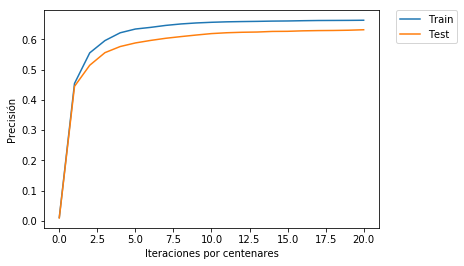

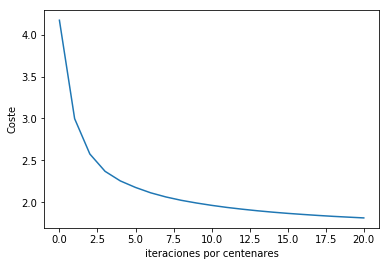

Tiemo de inicio 1537848757.5464158
Tiemo de final 1537848813.5689948


In [41]:
t_start=time.time()
m1 = Model1()
train(m1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 200 , imprimir=True)
t_fin=time.time()
print('Tiemo de inicio', t_start)
print('Tiemo de final', t_fin)
print('Diferencia de tiempo', diferencia)

   0, Loss: 4.164  Train accuracy: 0.012
   0, Loss: 4.133  Test accuracy: 0.023
  10, Loss: 2.969  Train accuracy: 0.451
  10, Loss: 3.046  Test accuracy: 0.410
  20, Loss: 2.530  Train accuracy: 0.562
  20, Loss: 2.603  Test accuracy: 0.515
  30, Loss: 2.326  Train accuracy: 0.601
  30, Loss: 2.413  Test accuracy: 0.566
  40, Loss: 2.203  Train accuracy: 0.617
  40, Loss: 2.312  Test accuracy: 0.586
  50, Loss: 2.118  Train accuracy: 0.624
  50, Loss: 2.241  Test accuracy: 0.591
  60, Loss: 2.052  Train accuracy: 0.627
  60, Loss: 2.183  Test accuracy: 0.598
  70, Loss: 1.999  Train accuracy: 0.631
  70, Loss: 2.138  Test accuracy: 0.605
  80, Loss: 1.956  Train accuracy: 0.636
  80, Loss: 2.098  Test accuracy: 0.610
  90, Loss: 1.919  Train accuracy: 0.639
  90, Loss: 2.066  Test accuracy: 0.612
 100, Loss: 1.887  Train accuracy: 0.641
 100, Loss: 2.037  Test accuracy: 0.613
 110, Loss: 1.860  Train accuracy: 0.642
 110, Loss: 2.012  Test accuracy: 0.615
 120, Loss: 1.836  Train acc

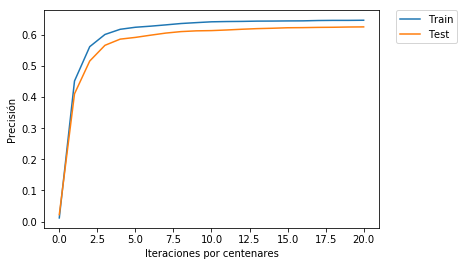

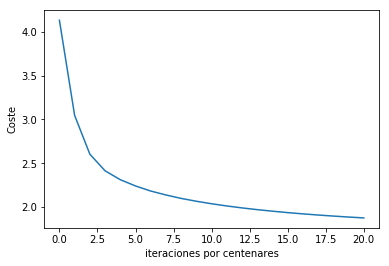

Tiemo de inicio 1537849115.929221
Tiemo de final 1537849168.7515018
Diferencia de tiempo 52.82


In [44]:
t_start=time.time()
m1_1 = Model1()
train(m1_1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 200 , imprimir=True)
t_fin=time.time()
print('Tiemo de inicio', t_start)
print('Tiemo de final', t_fin)
print('Tiempo', round(t_fin-t_start,2), 's')

   0, Loss: 4.092  Train accuracy: 0.039
   0, Loss: 3.991  Test accuracy: 0.084
  10, Loss: 2.620  Train accuracy: 0.527
  10, Loss: 2.768  Test accuracy: 0.484
  20, Loss: 2.073  Train accuracy: 0.639
  20, Loss: 2.209  Test accuracy: 0.563
  30, Loss: 1.824  Train accuracy: 0.701
  30, Loss: 1.941  Test accuracy: 0.654
  40, Loss: 1.674  Train accuracy: 0.736
  40, Loss: 1.792  Test accuracy: 0.692
  50, Loss: 1.569  Train accuracy: 0.749
  50, Loss: 1.691  Test accuracy: 0.715
  60, Loss: 1.489  Train accuracy: 0.759
  60, Loss: 1.621  Test accuracy: 0.731
  70, Loss: 1.427  Train accuracy: 0.766
  70, Loss: 1.566  Test accuracy: 0.740
  80, Loss: 1.375  Train accuracy: 0.772
  80, Loss: 1.522  Test accuracy: 0.747
  90, Loss: 1.332  Train accuracy: 0.778
  90, Loss: 1.483  Test accuracy: 0.751
 100, Loss: 1.296  Train accuracy: 0.781
 100, Loss: 1.450  Test accuracy: 0.756
 110, Loss: 1.264  Train accuracy: 0.782
 110, Loss: 1.421  Test accuracy: 0.758
 120, Loss: 1.236  Train acc

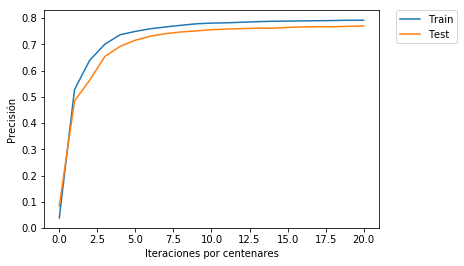

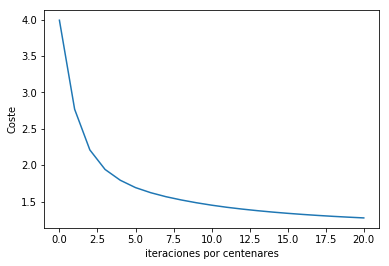

Tiemo de inicio 1537862752.9709256
Tiemo de final 1537862806.7572732
Tiempo 53.79 s


In [14]:
t_start=time.time()
m1_2 = Model1()
train(m1_2, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 200 , imprimir=True)
t_fin=time.time()
print('Tiemo de inicio', t_start)
print('Tiemo de final', t_fin)
print('Tiempo', round(t_fin-t_start,2), 's')

La accuracy del model depende del mínimo o máximo local en el que caiga al inicializar.  
Vamos a probar que pasa si entrenamos el modelo 5 veces.

In [16]:
for i in range(5):
    m1 = Model1()
    train(m1, X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, 200 , imprimir=False)

D:\ANACONDA\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
 199, Loss: 1.400  Train accuracy: 0.724
 199, Loss: 1.643  Test accuracy: 0.687
Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
 199, Loss: 1.760  Train accuracy: 0.632
 199, Loss: 1.782  Test accuracy: 0.650
Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
 199, Loss: 2.038  Train accuracy: 0.566
 199, Loss: 2.059  Test accuracy: 0.580
Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
 199, Loss: 1.177  Train accuracy: 0.780
 199, Loss: 1.214  Test accuracy: 0.781
Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
 199, Loss: 1.969  Train accuracy: 0.576
 199, Loss: 2.537  Test accuracy: 0.444


## 3. VISUALIZACIÓN DE LOS PESOS

In [15]:
def normalize(image):
    return (image-image.min())/(image.max()-image.min())

def display_images(images, titles=None, cols=5, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(11,11 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 9)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]

In [16]:
#label_exemplars= [X_train_orig[np.where(Y_train_orig == l)][:][:] for l in range(62)]
label_exemplars =[]
for i in range(62):
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_exemplars.append(X_train_orig[w])
            break
#label_counts = [np.count_nonzero(X_train_orig ==l ) for l in range(62)]
label_counts = []
for i in range(62):
    label_counts.append(0)
    for w in range(len(Y_train_orig)):
        if Y_train_orig[w] == i:
            label_counts[i] = label_counts[i]+1

In [17]:
# Loop trough the graph and print the names and shapes of all trainable variables
with m1_2.graph.as_default():
    for v in tf.trainable_variables():
        print(v.name, v.get_shape())

fully_connected/weights:0 (3072, 62)
fully_connected/biases:0 (62,)


In [19]:
#Get the values of the weight and bias variables.
m1_weights=m1_2.session.run("fully_connected/weights:0")
m1_biases=m1_2.session.run("fully_connected/biases:0")
print("weights shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_weights.shape, m1_weights.min(), m1_weights.max()))
print("biases shape: {!s:10}    min: {:.4f}    max: {:.4f}".format(m1_biases.shape, m1_biases.min(), m1_biases.max()))

weights shape: (3072, 62)    min: -0.1726    max: 0.1761
biases shape: (62,)         min: -0.0726    max: 0.1618


In [20]:
def display_weights(weights, limit):
    titles= ["Categoría {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
    images = list(zip(label_exemplars, weights.T.reshape(-1, 32, 32,3)))
    display_images(images[:limit], titles)

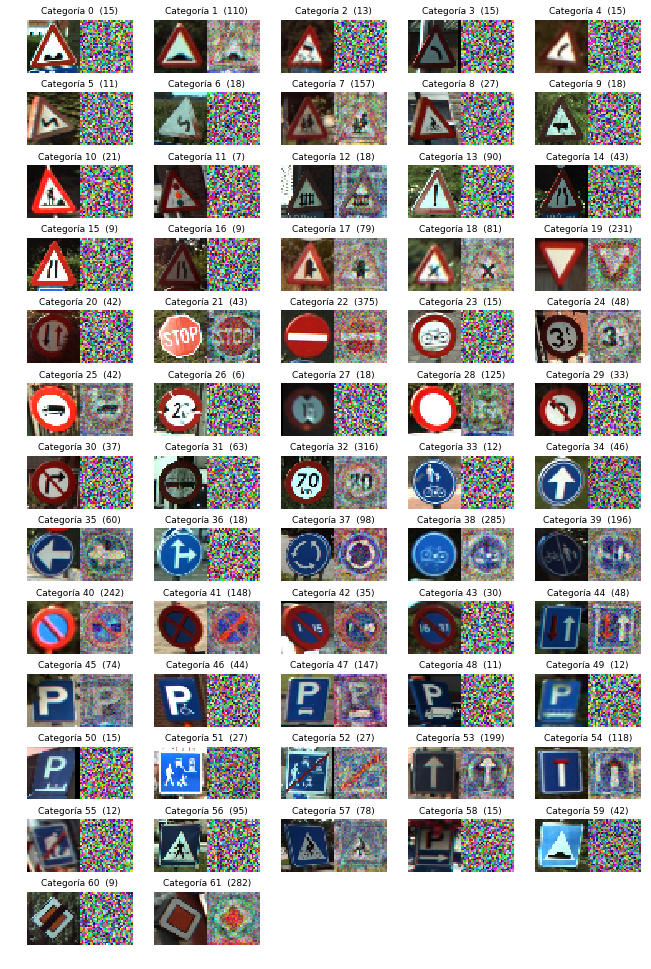

In [21]:
# Display weights of the first 30 labels
display_weights(m1_weights, 62)

In [22]:
def display_histograms(weights, title):
    cols = 5
    rows = math.ceil(len(weights[0])/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(weights[0]) is not np.ndarray else 1)
    plt.figure(figsize=(14,14 * 1))
    for i in range(len(weights[0])):
        plt.subplot(rows,cols,i+1)
        w = weights[:,i]
        plt.title(title[i], fontsize=8)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

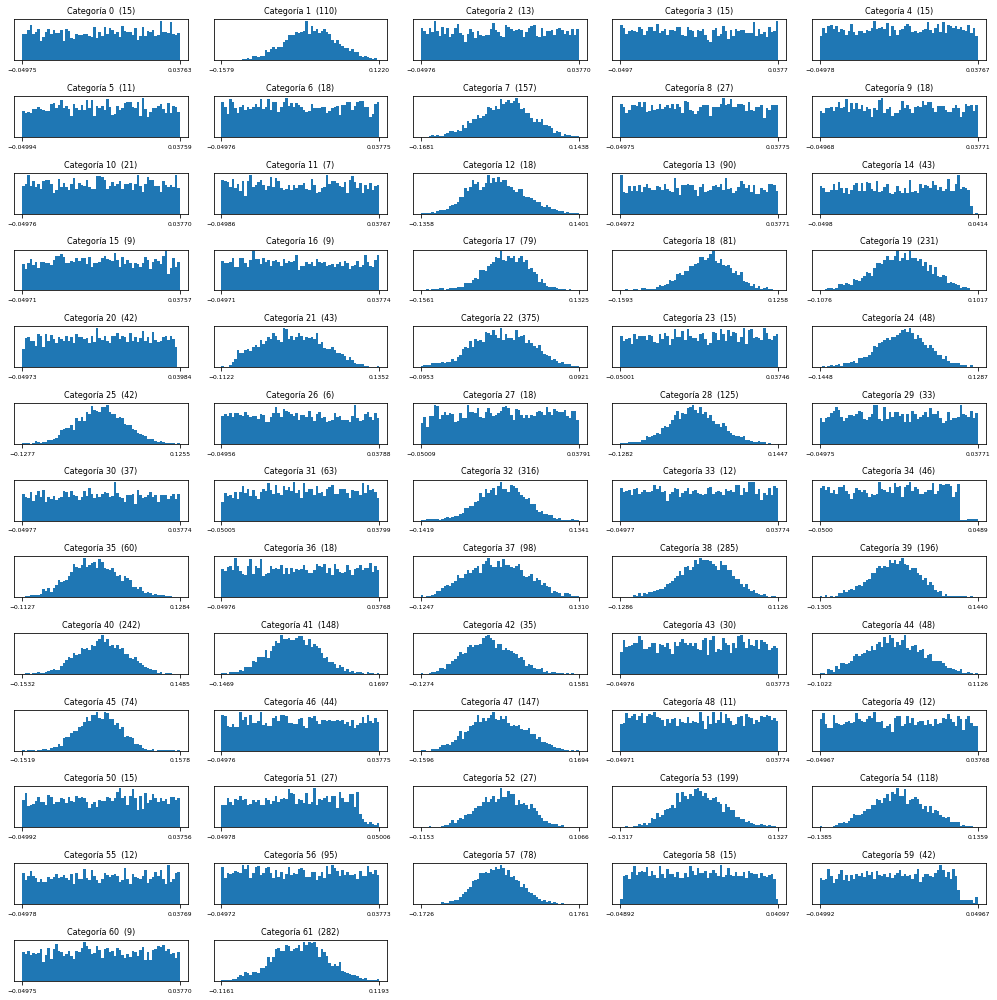

In [23]:
titles= ["Categoría {}  ({})".format(l,c) for l, c in enumerate(label_counts)]
display_histograms(m1_weights, titles)

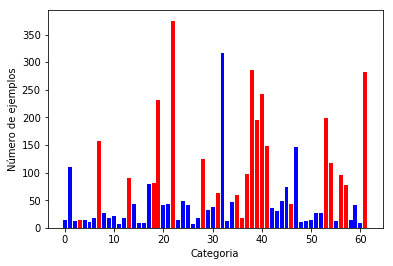

In [24]:
labels_count_x=list(range(62))
labels_count_y=label_counts
categorías_buenas = [4, 8, 14, 19, 20, 23, 29, 32, 36, 37, 38, 39, 40, 41, 42, 47, 54, 55, 57, 58, 62]

colores = []
for i in range(62):
    colores.append('blue')
for i in categorías_buenas:
    colores[i-1]='red'


plt.bar(labels_count_x,labels_count_y,color=colores)
plt.xlabel('Categoria')
plt.ylabel('Número de ejemplos')
plt.show()

In [26]:
m1_1_weights=m1_1.session.run("fully_connected/weights:0")
# Display weights of the first 30 labels
display_histograms(m1_1_weights, titles)

NameError: name 'm1_1' is not defined

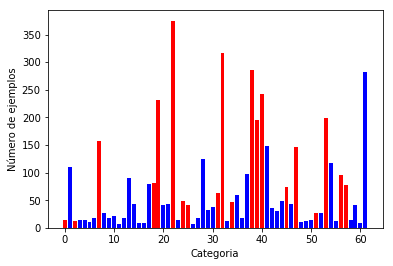

In [27]:
labels_count_x=list(range(62))
labels_count_y=label_counts
categorías_buenas = [0,2,7,18,19,22,24,25,31,32,34,38,39,40,45,47,53,56,57,51]

colores = []
for i in range(62):
    colores.append('blue')
for i in categorías_buenas:
    colores[i]='red'


plt.bar(labels_count_x,labels_count_y,color=colores)
plt.xlabel('Categoria')
plt.ylabel('Número de ejemplos')
plt.show()

## CONFUSSION MATRIX

In [28]:
print(__doc__)

#import sklearn
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Automatically created module for IPython interactive environment


In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


53
28
Confusion matrix, without normalization
[[  0   6   0 ...   0   0   0]
 [  0  27   0 ...   0   0   0]
 [  0   0   0 ...   0   0   1]
 ...
 [  0   8   0 ...   0   0   0]
 [  0   0   0 ...   0   0  10]
 [  0   0   0 ...   0   0 105]]
2520
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 105]


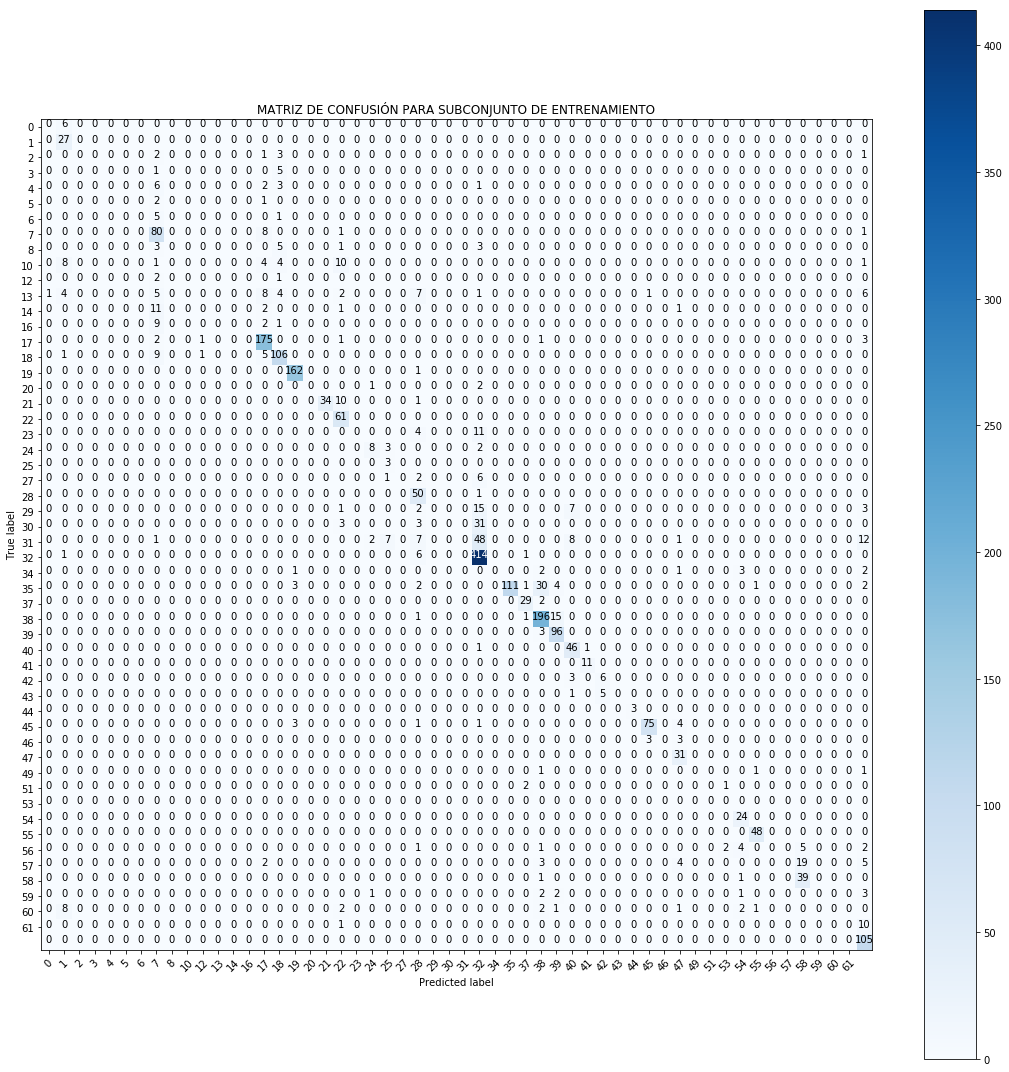

In [94]:
y_pred, _ = m1_2.session.run([m1_2.predicted_labels, m1_2.loss],
                                       {m1_2.images: X_test_orig, m1_2.labels:Y_test_orig})

y_test = Y_test_orig

#print(y_test)
#print(len(set(y_test)))
#print(y_pred)
print(len(set(y_test)))
print(len(set(y_pred)))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

class_names= list(set(Y_test_orig))

#Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='MATRIZ DE CONFUSIÓN PARA SUBCONJUNTO DE ENTRENAMIENTO')
#print(sum(sum(cnf_matrix)))
#print(cnf_matrix[53])
plt.show()

In [104]:
print("CATEGORIAS SUBCONJUNTO VAL.: ", y_test)
print('TOTAL: ',len(set(y_test)))

print('CATEGORIAS PREDICHAS POR EL MODELO: ',y_pred)
print('TOTAL:', len(set(y_pred)))


CATEGORIAS SUBCONJUNTO VAL.:  [ 0  0  0 ... 61 61 61]
TOTAL:  53
CATEGORIAS PREDICHAS POR EL MODELO:  [ 1  1  1 ... 61 61 61]
TOTAL: 28


In [120]:
#print(set(y_test))
no_duplicates = [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

In [121]:
cnf_matrix_t=cnf_matrix.transpose()
filas_0 = []
b=0
c=0
for col in cnf_matrix_t:
    contador = 0
    for a in col:
        if a != 0:
            contador += 1
    if contador == 0:
        filas_0.append(no_duplicates[b])
        c +=1
    b += 1
print(b)
print("Nº DE CATEGORÍAS SIN CLASIFICAR: ", c)
print("CATEGORÍaS NO CLASIFICADAS: ",filas_0)

54
Nº DE CATEGORÍAS SIN CLASIFICAR:  26
CATEGORÍaS NO CLASIFICADAS:  [2, 3, 4, 5, 6, 8, 10, 13, 14, 16, 20, 23, 27, 29, 30, 31, 34, 43, 46, 49, 51, 55, 56, 58, 59, 60]


In [ ]:
cat_no_rep = [9, 11, 15, 26, 33, 36, 48, 50, 52]
cnf_matrix_tot1 = []
i = 0
for col in cnf_matrix:
    cnf_matrix_tot1.append(col)
    #print(col)
    for cat in cat_no_rep:
        if i == cat:
            a = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0 ,0, 0, 0, 0, 0,0 ,0, 0, 0 ,0, 0]
            cnf_matrix_tot1.append(a)
    i+=1
  
    
#print(len(cnf_matrix_tot1))
cnf_matrix_tot2 = np.asarray(cnf_matrix_tot1)
cnf_matrix_tot2=cnf_matrix_tot2.transpose()
cnf_matrix_tot3 = []
i=0
for col in cnf_matrix_tot2:
    cnf_matrix_tot3.append(col)
    #print(col)
    for cat in cat_no_rep:
        if i == cat:
            a = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                 0, 0, 0,0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0 ,0, 0, 0, 0, 0,0 ,0, 0, 0 ,0, 0]
            cnf_matrix_tot3.append(a)
    i+=1
cnf_matrix_tot = np.asarray(cnf_matrix_tot3)
print(cnf_matrix_tot3)

class_names= list(set(Y_train_orig))

#Plot non-normalized confusion matrix
plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix_tot, classes=class_names,
                      title='MATRIZ DE CONFUSIÓN PARA SUBCONJUNTO DE ENTRENAMIENTO')

plt.show()

## PORCENTAJE DE ACIERTOS

In [131]:
label_count_test = []
cat_test = set(Y_test_orig)
i =0
for cat in cat_test:
    label_count_test.append(0)
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == cat:
            label_count_test[i] = label_count_test[i]+1
        
    i+=1
#print(sum(label_count_test))
#print(len(label_count_test))
#print(len(cat_test))

In [215]:
pred_count_test = []
for i in range(63):
    pred_count_test.append(0)

1

In [220]:
y_pred, _ = m1_2.session.run([m1_2.predicted_labels, m1_2.loss],
                                       {m1_2.images: X_test_orig, m1_2.labels:Y_test_orig})
y_test = Y_test_orig

   
for i in range(2520):
    if y_pred[i]==y_test[i]:
        cat = y_test[i]
        #print(cat)
        pred_count_test[cat]=pred_count_test[cat]+1


#print(len(pred_count_test))
precision = []
i=0
for cat in cat_test:
    precision.append(pred_count_test[cat]/label_count_test[i]*100)
    i+=1

prec = []
for preci in precision:
    prec.append(round(preci,2))

#print(y_pred)
#print(Y_test_orig)
#print(precision)
#print(len(pred_count_test))
#print(pred_count_test)
print(prec)

[0.0, 33.01, 0.0, 0.0, 0.0, 0.0, 0.0, 37.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.93, 50.33, 60.18, 0.0, 60.07, 42.6, 0.0, 47.06, 17.24, 0.0, 43.18, 0.0, 0.0, 0.0, 56.81, 0.0, 67.68, 61.7, 58.44, 59.48, 52.51, 66.27, 40.0, 0.0, 71.43, 67.2, 0.0, 50.49, 0.0, 0.0, 51.28, 67.8, 0.0, 0.0, 46.54, 0.0, 0.0, 0.0, 50.14]


In [221]:
label_exemplars_test =[]
for cat in cat_test:
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_exemplars_test.append(X_test_orig[w])
            break
#len(label_exemplars_test)
#len(cat_test)

In [222]:
def display_aciertos(images, titles=None, cols=7, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(16,16 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 12)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [225]:
cat_no_rep = [9, 11, 15, 26, 33, 36, 48, 50, 52]

titles_aciertos_hist=[]
#print(titles_aciertos_hist)
b=0
for i in range(62):
    a = 0
    #print('i',i)
    for cat in cat_no_rep:
        #print('cat',cat)
        if cat == i:
            titles_aciertos_hist.append('CAT. NO INCLUIDA')
            a = 1
            #print(a,'a')
            break
    if a == 0:
        titles_aciertos_hist.append(titles_aciertos[b]) 
        b+=1
    

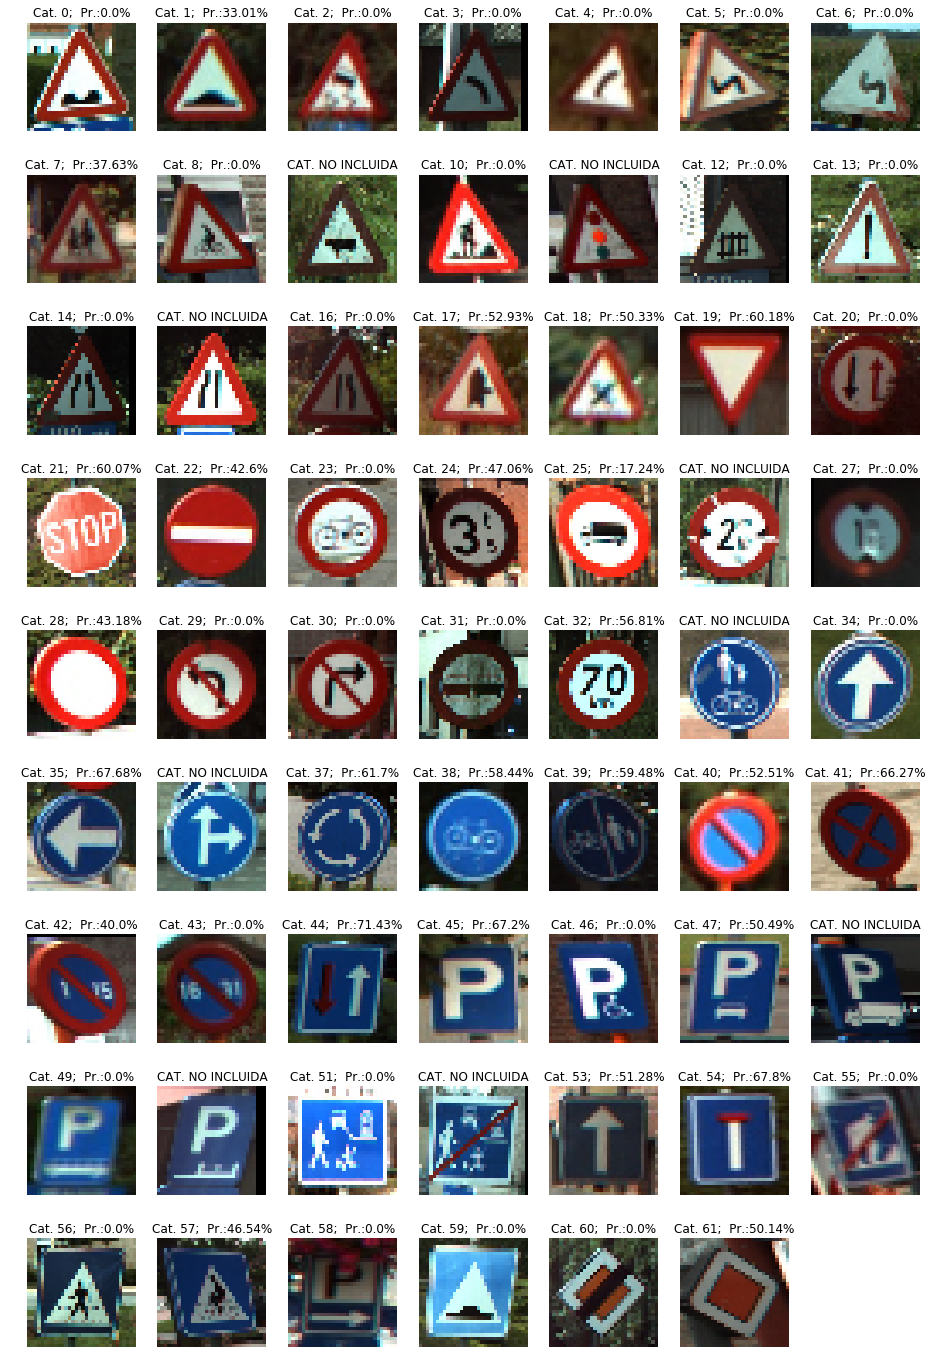

In [228]:
display_aciertos(label_exemplars, titles_aciertos_hist)

In [225]:
cat_no_rep = [9, 11, 15, 26, 33, 36, 48, 50, 52]

titles_aciertos_hist=[]
#print(titles_aciertos_hist)
b=0
for i in range(62):
    a = 0
    #print('i',i)
    for cat in cat_no_rep:
        #print('cat',cat)
        if cat == i:
            titles_aciertos_hist.append('CAT. NO INCLUIDA')
            a = 1
            #print(a,'a')
            break
    if a == 0:
        titles_aciertos_hist.append(titles_aciertos[b]) 
        b+=1
    

In [226]:
def display_histograms_test(weights, title):
    cols = 5
    rows = math.ceil(len(weights[0])/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(weights[0]) is not np.ndarray else 1)
    plt.figure(figsize=(14,14 * 1))
    for i in range(len(title)):
        plt.subplot(rows,cols,i+1)
        w = weights[:,i]
        plt.title(title[i], fontsize=10)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

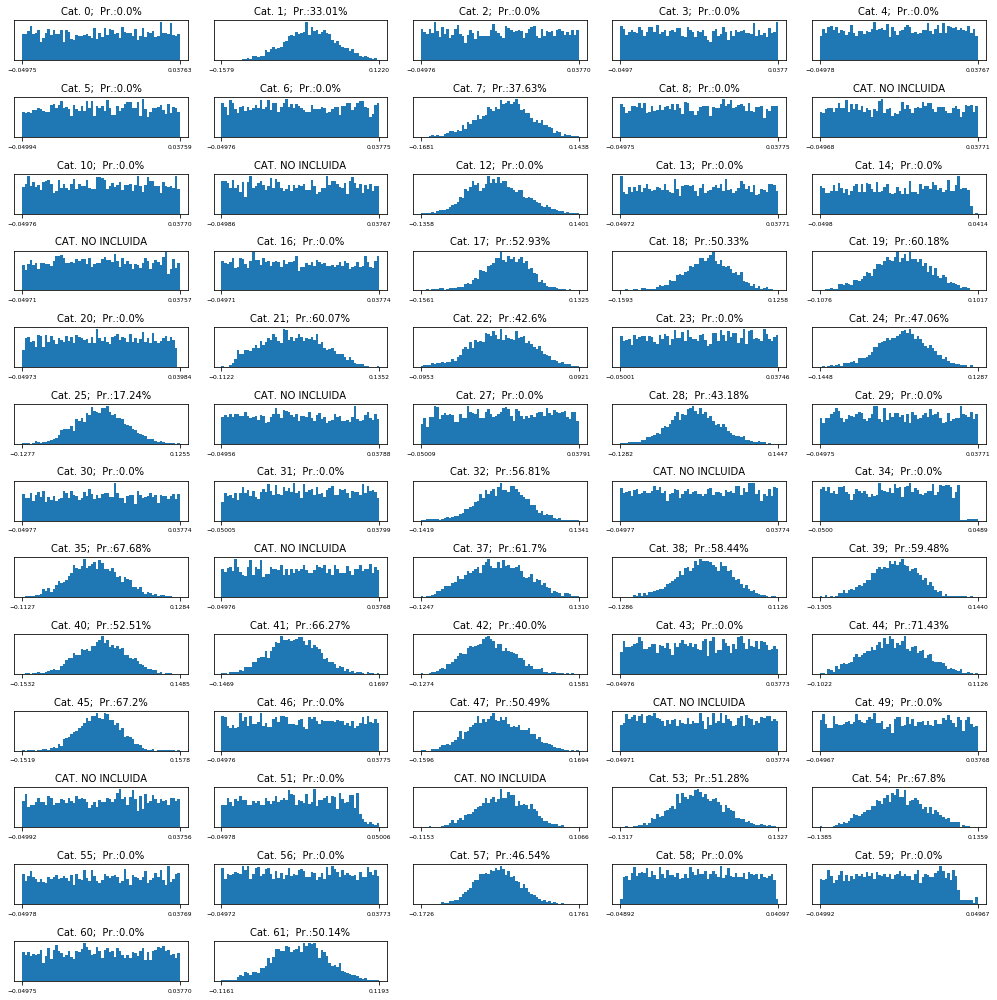

In [227]:
 display_histograms_test(m1_weights, titles_aciertos)

## PORCENTAJE DE ACIERTOS

In [75]:
def display_aciertos(images, titles=None, cols=7, interpolation=None):
    """ 
    images: A list of images. It can be either:
        + A list of Numpy arrays. Each array represents an image.
        + A list of lists of numpy arrays. In this casse, the images in the inner
          the inner lists are concatentated to make one image.
    
    """
    
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images)/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(16,16 * height_ratio))
    i=1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize = 12)
        plt.imshow(image, cmap="Greys_r", interpolation=interpolation)
        i += 1

In [83]:
label_exemplars_test =[]
cat_test=[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61]
for i in range(62):
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == i:
            label_exemplars_test.append(X_test_orig[w])
            break
#len(label_exemplars_test)
#len(cat_test)

In [84]:
label_count_test = []
cat_test=[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61]
i =0
for cat in cat_test:
    label_count_test.append(0)
    for w in range(len(Y_test_orig)):
        if Y_test_orig[w] == cat:
            label_count_test[i] = label_count_test[i]+1
        
    i+=1
#sum(label_count_test)
#len(label_count_test)

In [81]:
aciertos = [(round(cnf_matrix[i,i]/label_count_test[i]*100,2)) for i in range(53)]
len(cnf_matrix[0])

54

In [65]:
for cat in cat_test:
    titles_aciertos.append("Cat. "+str(cat)+";  Pr.:"+str(aciertos[i])+'%')
    i +=1
cat_no_rep = [9, 11, 15, 26, 33, 36, 48, 50, 52]

titles_aciertos_hist=[]
#print(titles_aciertos_hist)
b=0
for i in range(62):
    a = 0
    #print('i',i)
    for cat in cat_no_rep:
        #print('cat',cat)
        if cat == i:
            titles_aciertos_hist.append('CAT. NO INCLUIDA')
            a = 1
            #print(a,'a')
            break
    if a == 0:
        titles_aciertos_hist.append(titles_aciertos[b]) 
        b+=1
    

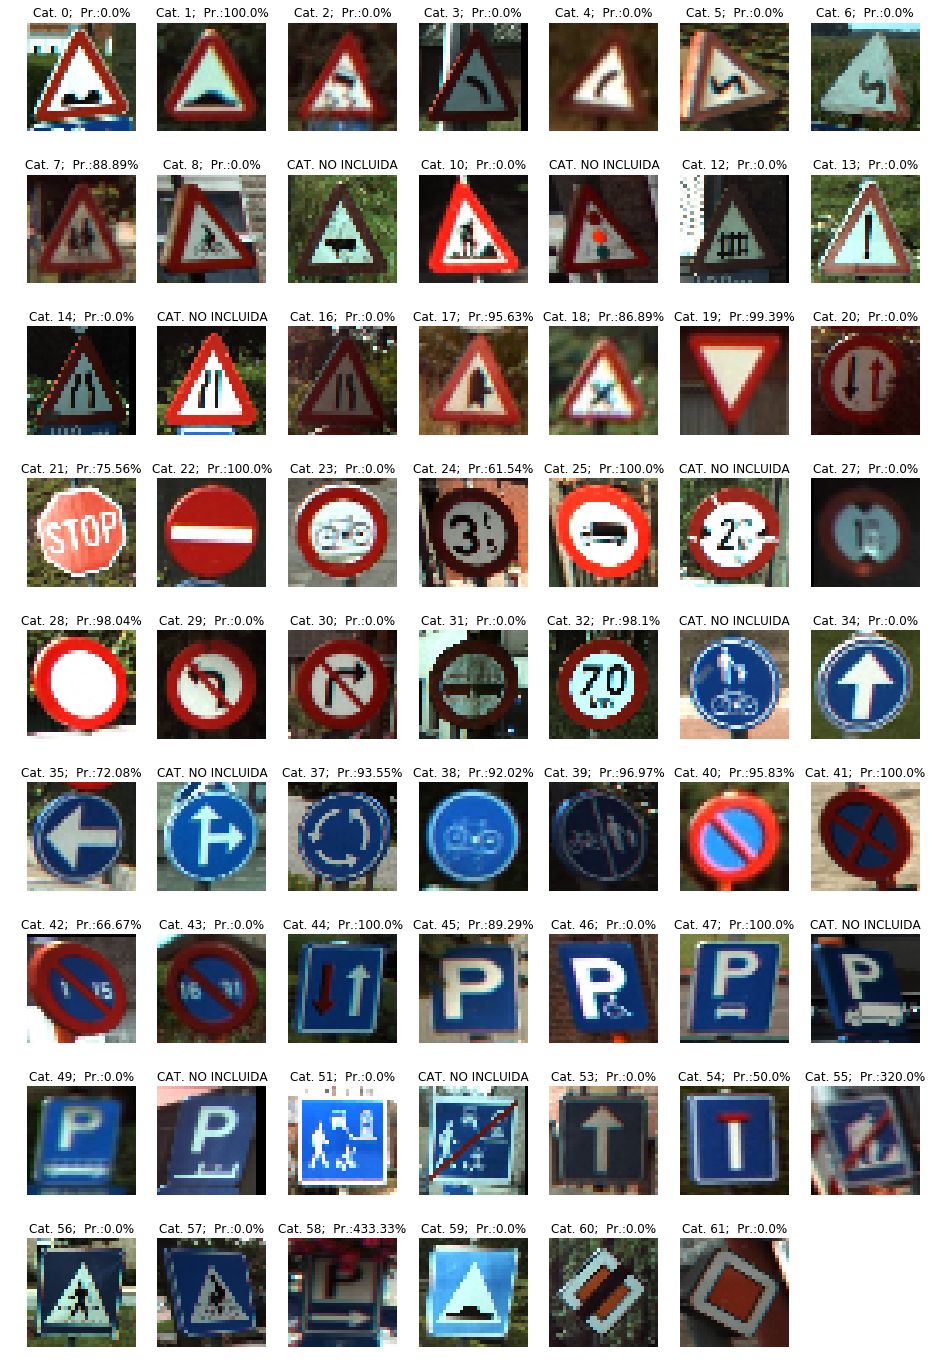

In [76]:

#print(len(aciertos))
#print(aciertos)
display_aciertos(label_exemplars, titles_aciertos_hist)

In [68]:
def display_histograms_test(weights, title):
    cols = 5
    rows = math.ceil(len(weights[0])/(cols))
    height_ratio =1.2*(rows/cols)*(0.5 if type(weights[0]) is not np.ndarray else 1)
    plt.figure(figsize=(14,14 * 1))
    for i in range(len(title)):
        plt.subplot(rows,cols,i+1)
        w = weights[:,i]
        plt.title(title[i], fontsize=10)
        plt.tick_params(labelsize=6)
        plt.yticks([])
        plt.xticks([w.min(),w.max()])
        plt.hist(w, bins=62)
    plt.tight_layout()

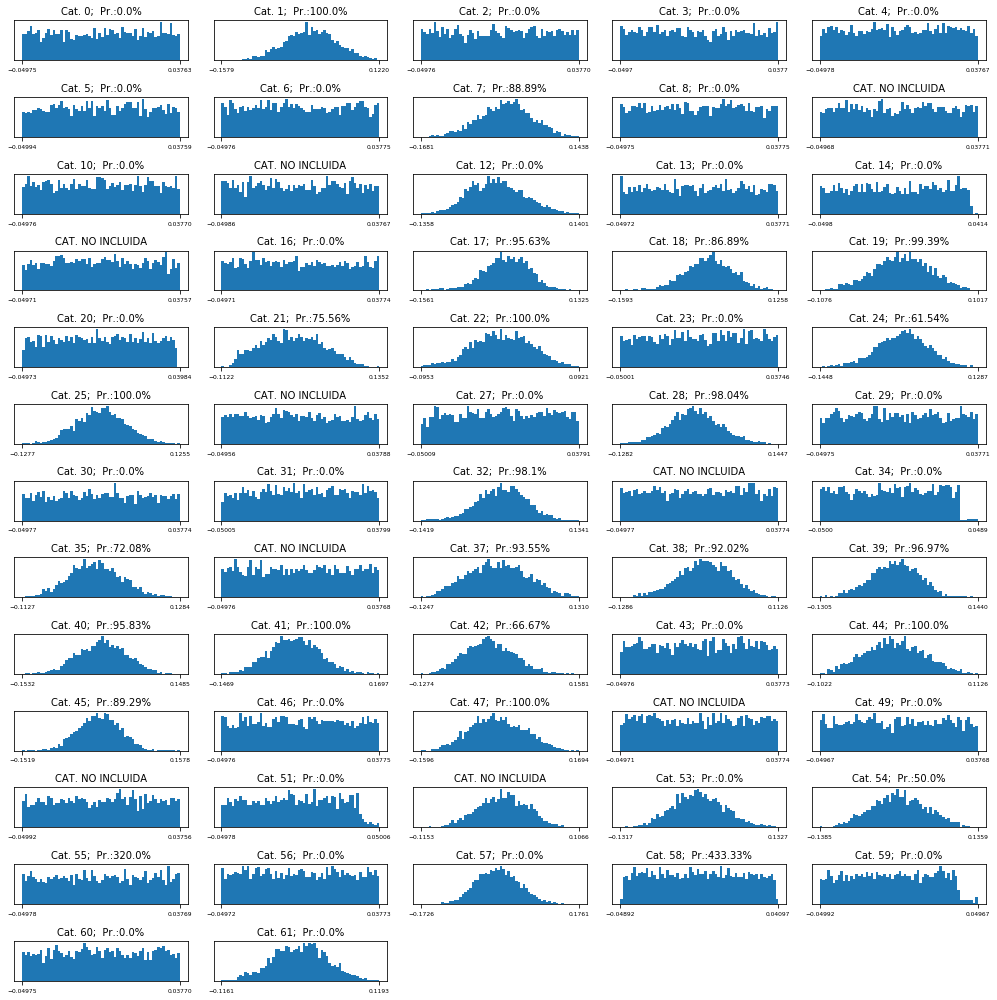

In [70]:
display_histograms_test(m1_weights, titles_aciertos_hist)